- Ignore this:

In [22]:
! jupyter nbconvert --output-dir='/Volumes/opto_loc/Data/ACHR_PROJECT_MATERIALS/ACHR_2/plots/' --to html --TemplateExporter.exclude_input=True --allow-errors ACHR_2_NEW.ipynb

[NbConvertApp] Converting notebook ACHR_2_NEW.ipynb to html
[NbConvertApp] Writing 5362661 bytes to /Volumes/opto_loc/Data/ACHR_PROJECT_MATERIALS/ACHR_2/plots/ACHR_2_NEW.html


# ACHR_2 Analysis Notebook

In [12]:
%matplotlib inline 
%reload_ext autoreload
%autoreload 2

import numpy as np
import scipy
import pandas as pd
import tdt
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import yaml
import re

import hypnogram as hp
from ecephys.utils import replace_outliers
import ecephys.plot as eplt
import ecephys.signal.timefrequency as tfr
import ecephys.signal.utils as kd
import ecephys.signal.kd_plotting as kp
import ecephys.signal.kd_pax as kpx
import tdt_xarray as tx

bands_def = dict(delta=(1, 4.0), theta=(4.0, 8), sigma=(11,16), beta = (13, 20), low_gamma = (40, 55), high_gamma = (65, 80))

kd_ref = {}
kd_ref['echans'] = [1,2,3]
kd_ref['fchans']=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
kd_ref['analysis_root'] = Path('/Volumes/opto_loc/Data/ACHR_PROJECT_MATERIALS/ACHR_2/ACHR_2-analysis-data')
kd_ref['tank_root'] = Path('/Volumes/opto_loc/Data/ACHR_2_TANK')

In [2]:
def plot_bp_set(spg, bands, hyp, channel, start_time, end_time, ss=12, figsize=(15,5), title=None):
    spg = spg.sel(channel=channel, time=slice(start_time, end_time))
    bp_set = kd.get_bp_set2(spg, bands)
    bp_set = kd.get_smoothed_ds(bp_set, smoothing_sigma=ss)
    ax_index = np.arange(0, len(bands))
    keys = kd.get_key_list(bands)

    fig, axes = plt.subplots(ncols=1, nrows=len(bands), figsize=figsize)

    for i, k in zip(ax_index, keys):
        fr = bp_set[k].f_range
        fr_str = '('+str(fr[0]) + ' -> ' +str(fr[1])+' Hz)'
        ax = sns.lineplot(x=bp_set[k].time, y=bp_set[k], ax=axes[i])
        ax.set_ylabel('Raw '+k.capitalize()+' Power')
        ax.set_title(k.capitalize()+' Bandpower '+fr_str)
    fig.suptitle(title)
    fig.tight_layout(pad=1)
    return fig, axes

# Test-a1

In [ ]:
a1p = '/Volumes/opto_loc/Data/ACHR_2_TANK/ACHR_2-test-a1'
a2p = '/Volumes/opto_loc/Data/ACHR_2_TANK/ACHR_2-test-a2'
a3p = '/Volumes/opto_loc/Data/ACHR_2_TANK/ACHR_2-test-a3'
a4p = '/Volumes/opto_loc/Data/ACHR_2_TANK/ACHR_2-test-a4'
a5p = '/Volumes/opto_loc/Data/ACHR_2_TANK/ACHR_2-test-a5'

In [ ]:
tt = {}

In [ ]:
tt['a1_er'], tt['a1_erspg'] = kd.get_data_spg(a1p, store='EEGr', t1=0, t2=0, channel=kd_ref['echans'])
tt['a1_e'], tt['a1_espg'] = kd.get_data_spg(a1p, store='EEG_', t1=0, t2=0, channel=kd_ref['echans'])
tt['a1_f'], tt['a1_fspg'] = kd.get_data_spg(a1p, store='LFP_', t1=0, t2=0, channel=kd_ref['fchans'])

tt['a2_er'], tt['a2_erspg'] = kd.get_data_spg(a2p, store='EEGr', t1=0, t2=0, channel=kd_ref['echans'])
tt['a2_e'], tt['a2_espg'] = kd.get_data_spg(a2p, store='EEG_', t1=0, t2=0, channel=kd_ref['echans'])
tt['a2_f'], tt['a2_fspg'] = kd.get_data_spg(a2p, store='LFP_', t1=0, t2=0, channel=kd_ref['fchans'])

tt['a3_er'], tt['a3_erspg'] = kd.get_data_spg(a3p, store='EEGr', t1=0, t2=0, channel=kd_ref['echans'])
tt['a3_e'], tt['a3_espg'] = kd.get_data_spg(a3p, store='EEG_', t1=0, t2=0, channel=kd_ref['echans'])
tt['a3_f'], tt['a3_fspg'] = kd.get_data_spg(a3p, store='LFP_', t1=0, t2=0, channel=kd_ref['fchans'])

tt['a4_er'], tt['a4_erspg'] = kd.get_data_spg(a4p, store='EEGr', t1=0, t2=0, channel=kd_ref['echans'])
tt['a4_e'], tt['a4_espg'] = kd.get_data_spg(a4p, store='EEG_', t1=0, t2=0, channel=kd_ref['echans'])
tt['a4_f'], tt['a4_fspg'] = kd.get_data_spg(a4p, store='LFP_', t1=0, t2=0, channel=kd_ref['fchans'])

In [ ]:
keys = ['a1-Filtered-EEG', 'a3-Filtered-EEG']
test = 'Recording-Config'
def comp_psd(spg1, spg2, median=True, keys=keys, test=test):
    psd1 = spg1.median(dim='time')
    psd2 = spg2.median(dim='time')
    if median is not True: 
        psd1 = spg1.mean(dim='time')
        psd2 = spg2.mean(dim='time')
    psd_df = pd.concat([psd1.to_dataframe('power'), psd2.to_dataframe('power')], keys=keys).rename_axis(index={None: test})
    ax = sns.relplot(data=psd_df, x='frequency', y='power', hue='Recording-Config', col='channel', kind='line')
    x = ax.axes
    x[0,0].set_ylim(0, 250)
    x[0,0].set_xlim(0, 120)
    return ax

In [ ]:

def comp_psd_lfp(spg1, spg2, median=True, keys=keys, test=test, chans=chans):
    psd1 = spg1.sel(channel=chans).median(dim='time')
    psd2 = spg2.sel(channel=chans).median(dim='time')
    if median is not True: 
        psd1 = spg1.sel(channel=chans).mean(dim='time')
        psd2 = spg2.sel(channel=chans).mean(dim='time')
    psd_df = pd.concat([psd1.to_dataframe('power'), psd2.to_dataframe('power')], keys=keys).rename_axis(index={None: test})
    ax = sns.relplot(data=psd_df, x='frequency', y='power', hue='Recording-Config', col='channel', kind='line')
    return ax

In [ ]:

fkeys = ['a2-Filtered-LFP', 'a3-Filtered-LFP']
test = 'Recording-Config'
chans = [3,7,11,15]
plt.close('all')
ax = comp_psd_lfp(tt['a2_fspg'], tt['a3_fspg'], keys=fkeys)

x = ax.axes
#x[0,0].set_ylim(0, 250)
x[0,0].set_xlim(0, 70)

In [ ]:
plt.close('all')
band='delta'
chans = [3,8,15]
for chan in chans:
    b, s = kp.plot_spectrogram_with_bandpower(tt['a1_espg'], bands_def, band, hyp=None, channel=chan, start_time=0, end_time=spg.time.max(), title=band.capitalize()+" Power, LFP/EEG-"+str(chan)+", EXPERIMENT")
    #b.set_ylim(0, 300000)

# Exp-1

In [ ]:
def stim_durations(onsets, offsets, num):
    durations = list()
    num=num+1
    stims = np.arange(1,num,1)
    for on, off in zip(onsets, offsets):
        dur = off-on
        durations.append(dur)
    return durations
def stim_values(onsets, offsets, num):
    for pulse in zip(onsets, offsets):
        print(pulse)

In [ ]:
d = stim_durations(a2x1['stim_on'], a2x1['stim_off'], 11)
d

In [ ]:
stim_values(a2x1['stim_on'], a2x1['stim_off'], 11)

In [ ]:
x1p = '/Volumes/opto_loc/Data/ACHR_2/ACHR_2_TANK/ACHR_2-exp1'
#comment

In [ ]:
a2x1 = {}
a2x1['e'], a2x1['espg'] = kd.get_data_spg(x1p, store='EEG_', t1=0, t2=0, channel=kd_ref['echans'])
a2x1['f'], a2x1['fspg'] = kd.get_data_spg(x1p, store='LFP_', t1=0, t2=0, channel=kd_ref['fchans'])

In [ ]:
a2x1['stim_on'] = tdt.read_block(x1p, evtype=['epocs']).epocs.Bn1_.onset 
a2x1['stim_off'] = tdt.read_block(x1p, evtype=['epocs']).epocs.Bn1_.offset 

# EXPERIMENT #4

In [3]:
x4p = '/Volumes/opto_loc/Data/ACHR_2/ACHR_2_TANK/ACHR_2-exp4-laser-recovery'
x4sdp = '/Volumes/opto_loc/Data/ACHR_2/ACHR_2_TANK/ACHR_2-exp4-laser-sd'
b4p = '/Volumes/opto_loc/Data/ACHR_2/ACHR_2_TANK/ACHR_2-exp4-laser-bl'

In [ ]:
a2x4 = {}
a2x4['bl-ze'], a2x4['blspg-ze'] = kd.get_data_spg(b4p, store='EEG_', t1=0, t2=0, channel=kd_ref['echans'])

a2x4['bl-zf'], a2x4['blspg-zf'] = kd.get_data_spg(b4p, store='LFP_', t1=0, t2=0, channel=kd_ref['fchans'])

a2x4['rec-ze'], a2x4['recspg-ze'] = kd.get_data_spg(x4p, store='EEG_', t1=0, t2=0, channel=kd_ref['echans'])
a2x4['rec-zf'], a2x4['recspg-zf'] = kd.get_data_spg(x4p, store='LFP_', t1=0, t2=0, channel=kd_ref['fchans'])

a2x4['sd-ze'], a2x4['sdspg-ze'] = kd.get_data_spg(x4sdp, store='EEG_', t1=0, t2=0, channel=kd_ref['echans'])
a2x4['sd-zf'], a2x4['sdspg-zf'] = kd.get_data_spg(x4sdp, store='LFP_', t1=0, t2=0, channel=kd_ref['fchans'])

- Experiment-4 LFP-14 plots

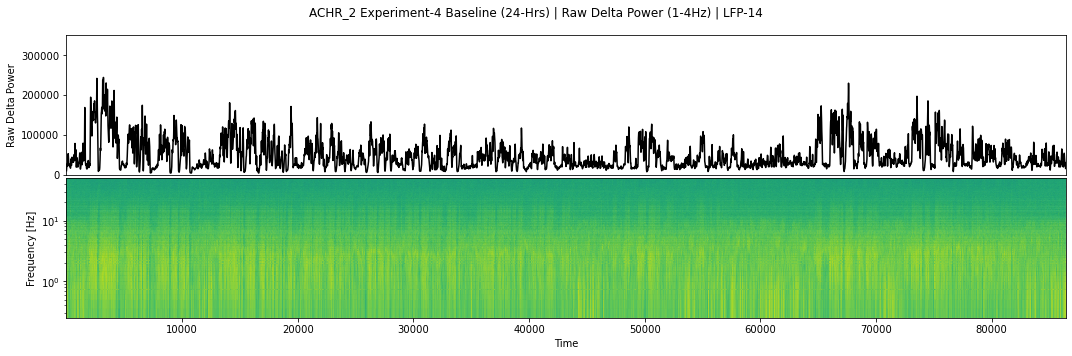

In [13]:
title = "ACHR_2 Experiment-4 Baseline (24-Hrs) | Raw Delta Power (1-4Hz) | LFP-"
plt.close('all')
band='delta'
spg = a2x4['blspg-zf']
chans = [14]
for chan in chans:
    b, s = kp.plot_spectrogram_with_bandpower(spg, bands_def, band, hyp=None, channel=chan, start_time=0, end_time=86400, title=title+str(chan))
    b.set_ylim(0, 350000)

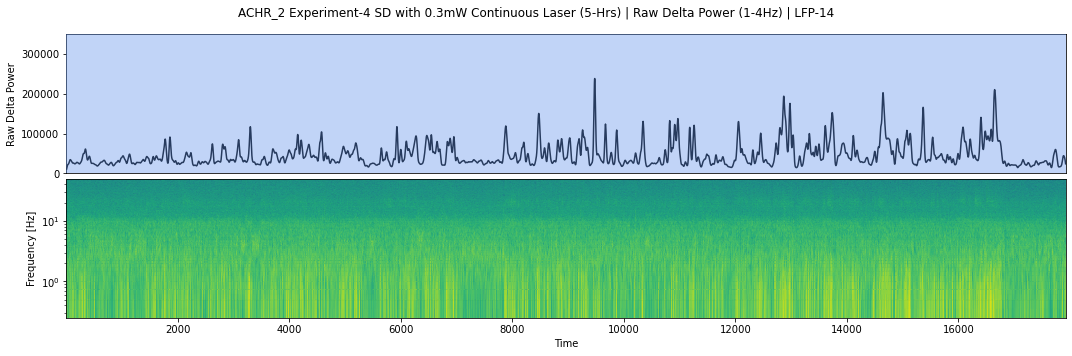

In [16]:
title = "ACHR_2 Experiment-4 SD with 0.3mW Continuous Laser (5-Hrs) | Raw Delta Power (1-4Hz) | LFP-"
plt.close('all')
band='delta'
spg = a2x4['sdspg-zf']
chans = [14]
for chan in chans:
    b, s = kp.plot_spectrogram_with_bandpower(spg, bands_def, band, hyp=None, channel=chan, start_time=0, end_time=spg.time.max(), title=title+str(chan))
    b.set_ylim(0, 350000)
    b.axvspan(
        0,
        spg.time.max(),
        alpha=0.4,
        color='cornflowerblue',
        zorder=1000,
        ec="none",
    )

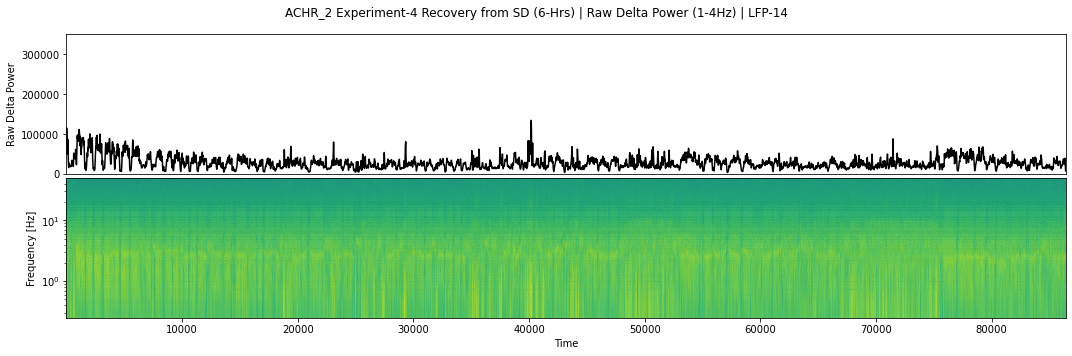

In [23]:
title = "ACHR_2 Experiment-4 Recovery from SD (6-Hrs) | Raw Delta Power (1-4Hz) | LFP-"
plt.close('all')
band='delta'
spg = a2x4['recspg-zf']
chans = [14]
for chan in chans:
    b, s = kp.plot_spectrogram_with_bandpower(spg, bands_def, band, hyp=None, channel=chan, start_time=0, end_time=86400, title=title+str(chan))
    b.set_ylim(0, 350000)

- Experiment-4 EEG plots

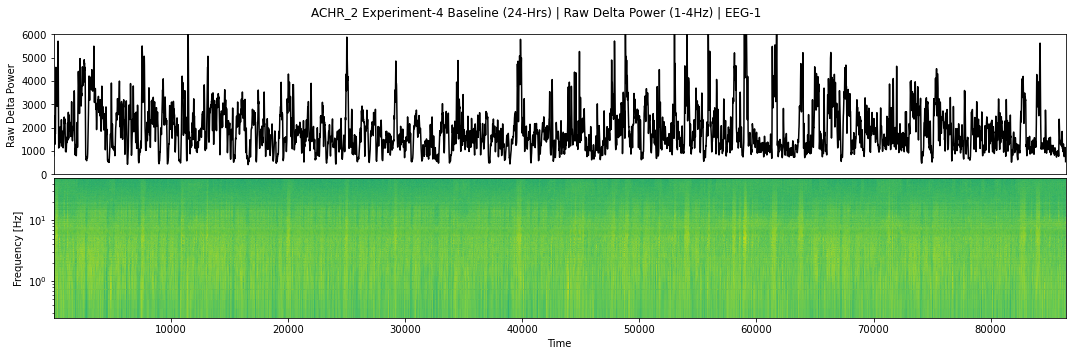

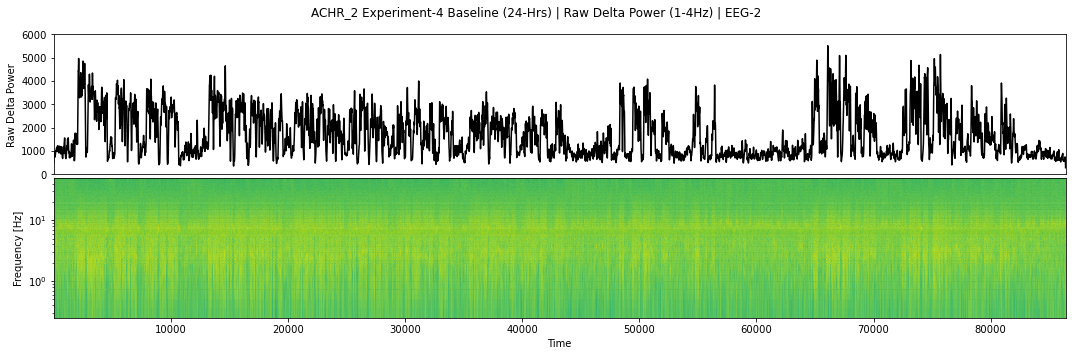

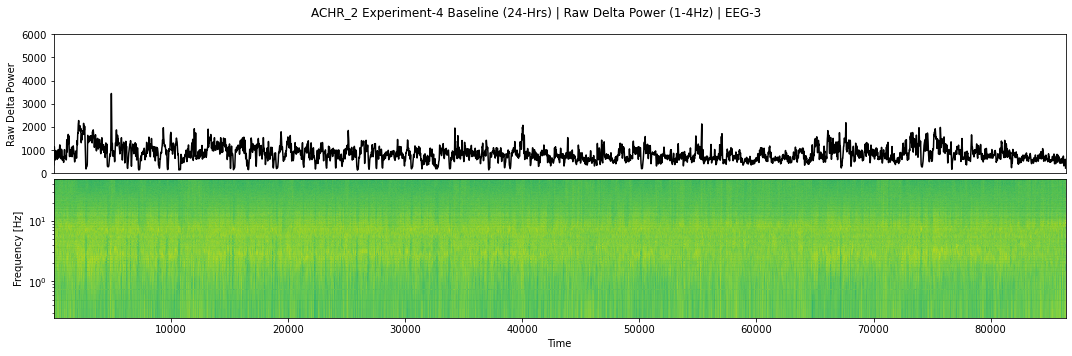

In [18]:
title = "ACHR_2 Experiment-4 Baseline (24-Hrs) | Raw Delta Power (1-4Hz) | EEG-"
plt.close('all')
band='delta'
spg = a2x4['blspg-ze']
chans = [1,2,3]
for chan in chans:
    b, s = kp.plot_spectrogram_with_bandpower(spg, bands_def, band, hyp=None, channel=chan, start_time=0, end_time=86400, title=title+str(chan))
    b.set_ylim(0, 6000)

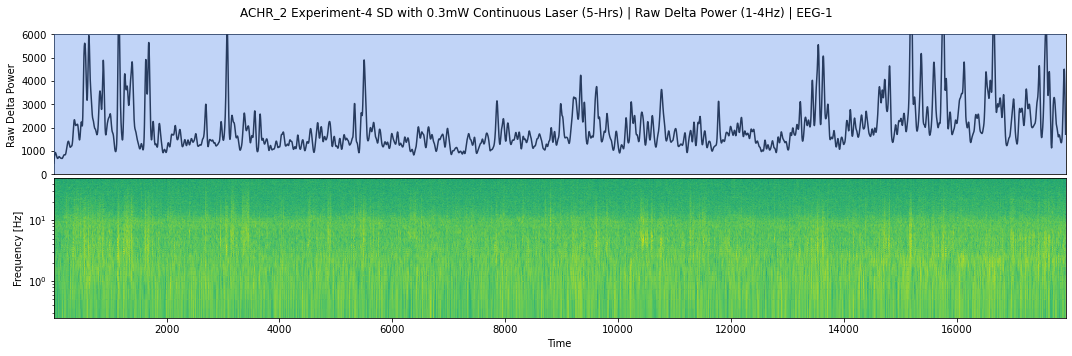

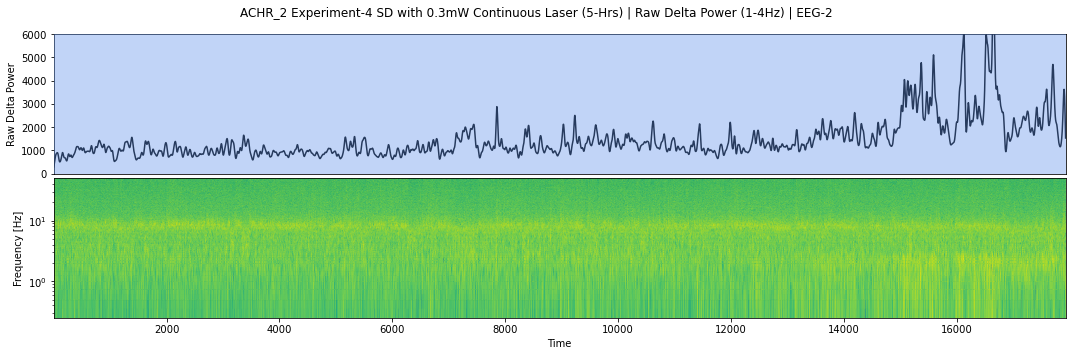

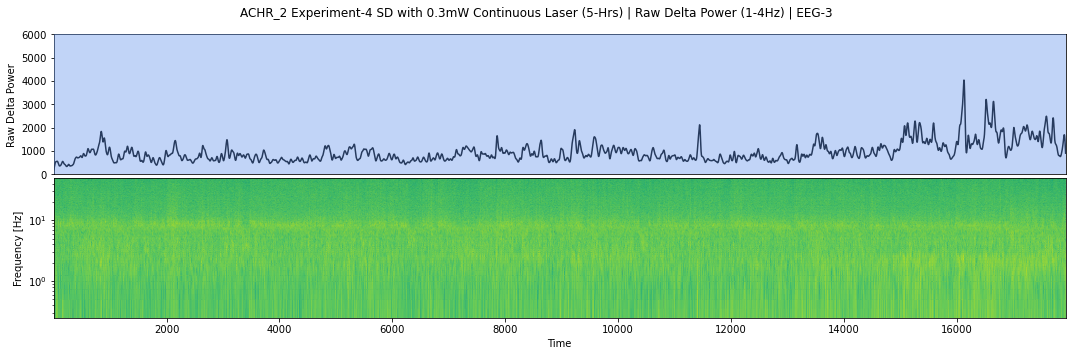

In [21]:
title = "ACHR_2 Experiment-4 SD with 0.3mW Continuous Laser (5-Hrs) | Raw Delta Power (1-4Hz) | EEG-"
plt.close('all')
band='delta'
spg = a2x4['sdspg-ze']
chans = [1,2,3]
for chan in chans:
    b, s = kp.plot_spectrogram_with_bandpower(spg, bands_def, band, hyp=None, channel=chan, start_time=0, end_time=spg.time.max(), title=title+str(chan))
    b.set_ylim(0, 6000)
    b.axvspan(
        0,
        spg.time.max(),
        alpha=0.4,
        color='cornflowerblue',
        zorder=1000,
        ec="none",
    )

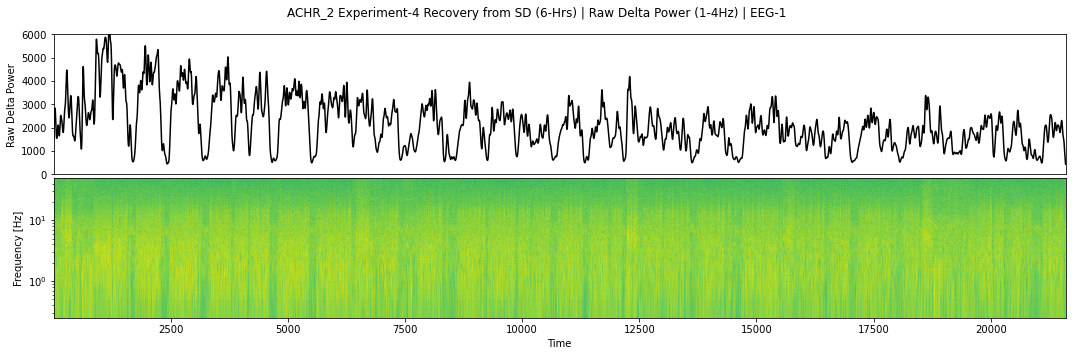

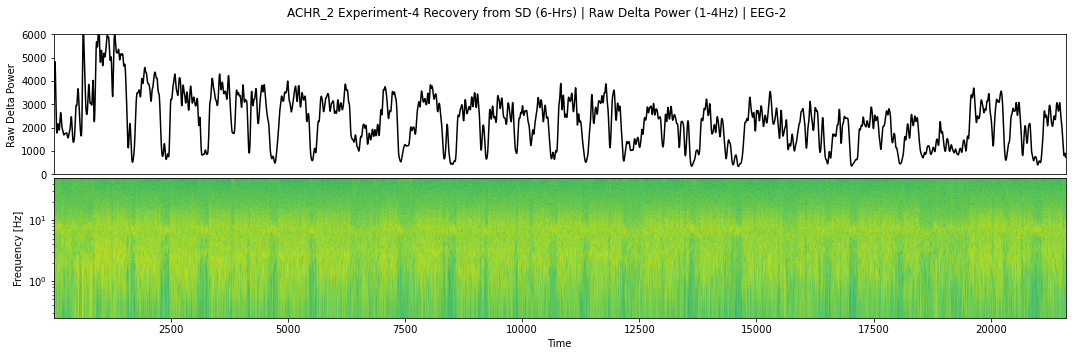

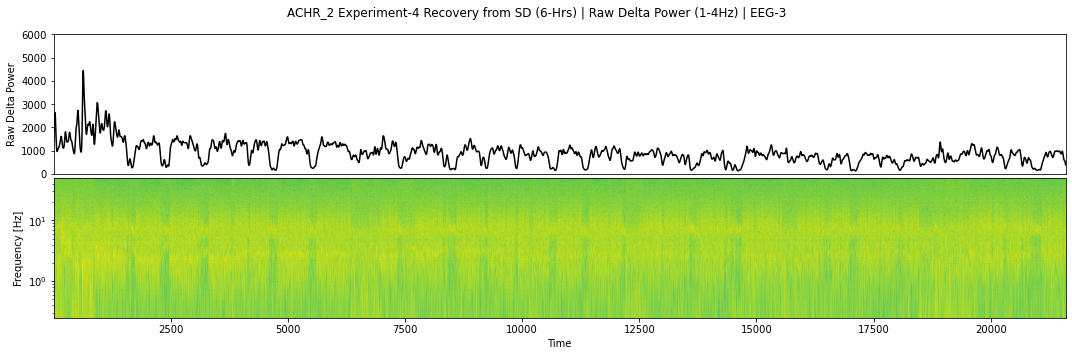

In [20]:
title = "ACHR_2 Experiment-4 Recovery from SD (6-Hrs) | Raw Delta Power (1-4Hz) | EEG-"
plt.close('all')
band='delta'
spg = a2x4['recspg-ze']
chans = [1,2,3]
for chan in chans:
    b, s = kp.plot_spectrogram_with_bandpower(spg, bands_def, band, hyp=None, channel=chan, start_time=0, end_time=21600, title=title+str(chan))
    b.set_ylim(0, 6000)